In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

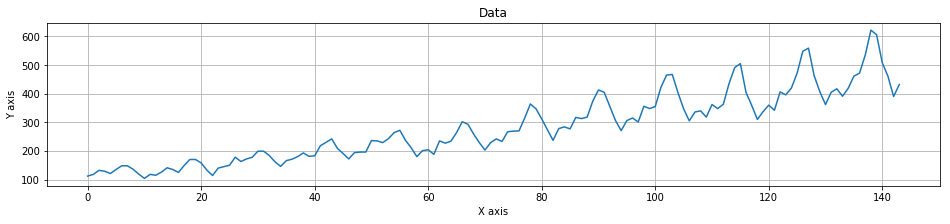

In [2]:
fileName = 'datosT1P2.txt'
data = np.loadtxt(fileName)

fig = plt.figure(0,(16,3))
plt.plot(data[:,0],data[:,1])
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.grid()
plt.show(fig)

Total data: 144
Train data: 108
Test data : 36


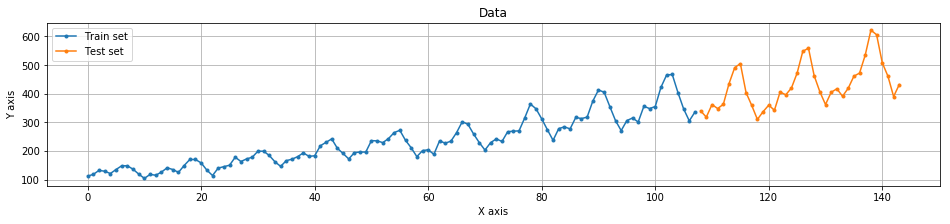

(0.0, 107.0)
(112.0, 336.0)


In [3]:
nData = data.shape[0]
nTrain = int(np.ceil(0.75*nData))

print('Total data: %i\nTrain data: %i\nTest data : %i' %(nData, nTrain, nData-nTrain))

train_set = data[0:nTrain,:]
test_set  = data[nTrain:,:]

fig = plt.figure(0,(16,3))
plt.plot(train_set[:,0],train_set[:,1],'.-')
plt.plot(test_set[:,0],test_set[:,1],'.-')
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend(('Train set', 'Test set'))
plt.grid()
plt.show(fig)

print(train_set[0,0],train_set[-1,0])
print(train_set[0,1],train_set[-1,1])

# Model

This model have the following structure:

$$
y = f_{\theta} + \eta
$$

where, $\eta\sim N(0,\sigma_{\eta}^2)$ and $\theta$ are the parameters for $f(\cdot)$. Then, the probability associated to $(x,y)$ is given by:

$$
p(y|f(\cdot), x) = \frac{1}{\sqrt{2\pi\sigma_{\eta}^2}}\exp{\left(-\frac{(y-f(x))^2}{2\sigma_{\eta}^2}\right)}
$$

In this case, the model for $f(\cdot)$ is a polynomial. Then, $\theta = [\theta_0, \theta_1, ..., \theta_n]$ where:

$$
f(x) = \theta_0 + \theta_1x + ...+ \theta_n x^n
$$

In [4]:
import theano.tensor as tt

grade = 3

k = np.linspace(0,grade,grade+1)
X = train_set[:,0]
print('X shape: %s' % X.shape)

Y = train_set[:,1]
print('Y shape: %s' % Y.shape)


basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    theta = pm.Normal('theta', mu=0, sd=100, shape = 4)
    # theta3 = pm.Normal('theta3', mu=0, sd=100)
    # sigma = pm.HalfNormal('sigma', sd=10)
    sigma = pm.HalfNormal('sigma_y', sd=200)

    # Expected value of outcome
    mu_obs = theta[3]+theta[2]*X+theta[1]*np.power(X,2)+theta[0]*np.power(X,3)
    # mu_obs = np.sum(np.dot(theta,X_aux),axis = 1)
    print('mu_obs shape: %s'% mu_obs.shape)
        
    # Model
    Y_obs = pm.Normal('Y_obs', mu=mu_obs, sd=sigma, observed=Y)
    
    ## sample using MEtropolis
    # step = pm.Metropolis()
    # trace = pm.sample(10000, step)

map_estimate = pm.find_MAP(model=basic_model)

print(map_estimate)

X shape: 108
Y shape: 108
mu_obs shape: Shape.0
         Current function value: 556.650576
         Iterations: 24
         Function evaluations: 34
         Gradient evaluations: 33
{'theta': array([  5.99619188e-05,   1.88173354e-03,   1.67822972e+00,
         1.15242938e+02]), 'sigma_y_log_': array(3.5102102930808257)}


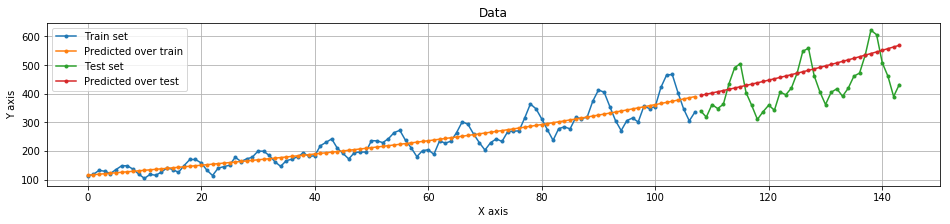

In [5]:
# theta = [float(map_estimate['theta1']),float(map_estimate['theta0'])]
theta = map_estimate['theta']
# theta = [float(map_estimate['theta3']), float(map_estimate['theta2']), float(map_estimate['theta1']),float(map_estimate['theta0'])]

X_test = test_set[:,0]
Y_test = test_set[:,1]

Y_train_hat_pol = np.polyval(theta,X)
Y_hat_pol = np.polyval(theta,X_test)

fig = plt.figure(0,(16,3))
plt.plot(X,Y,'.-')
plt.plot(X,Y_train_hat_pol,'.-')
plt.plot(X_test,Y_test,'.-')
plt.plot(X_test,Y_hat_pol ,'.-')
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend(('Train set', 'Predicted over train', 'Test set', 'Predicted over test'))
plt.grid()
plt.savefig('final.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show(fig)

In [6]:
import mle
import theano.tensor as tt
import theano

# for ommit AttributeError: x has no test value
theano.config.compute_test_value = 'ignore'

def fpol(a,x):
    return a[3]+a[2]*x+a[1]*np.power(x,2)+a[0]*np.power(x,3)

X = train_set[:,0]

print('X shape: %s' % X.shape)

Y = train_set[:,1]
print('Y shape: %s' % Y.shape)

# Define model
x = mle.var('x', observed=True, vector=True)
y = mle.var('y', observed=True, vector=True)

theta1 = mle.var('theta1')
theta2 = mle.var('theta2')
theta3 = mle.var('theta3')
theta4 = mle.var('theta4')
sigma = mle.var('sigma')



model = mle.Normal(y, theta[3]+theta[2]*X+theta[1]*np.power(X,2)+theta[0]*np.power(X,3) + theta1*tt.sin(theta2*x + theta3)*tt.exp(theta4*x), sigma)


# Fit model to data
result = model.fit({'x': X, 'y': Y}, {'theta1': 100, 'theta2': 60, 'theta3': 10, 'theta4': 0.01, 'sigma': 1})
print(result)

X shape: 108
Y shape: 108
         Current function value: 467.374536
         Iterations: 120
         Function evaluations: 226
         Gradient evaluations: 214
 fit_time: 0.08729600000000026
      fun: 467.3745363675823
 hess_inv: array([[  1.54146985e+00,   2.50667059e-02,  -3.22303623e-05,
          2.29731927e-03,  -2.18212871e-05],
       [  2.50667059e-02,   7.76891717e+00,  -1.54145511e-04,
          1.99409270e-02,  -7.49983979e-03],
       [ -3.22303623e-05,  -1.54145511e-04,   6.61098250e-06,
         -5.48440633e-04,   1.87088259e-07],
       [  2.29731927e-03,   1.99409270e-02,  -5.48440633e-04,
          4.92423024e-02,  -2.32541435e-05],
       [ -2.18212871e-05,  -7.49983979e-03,   1.87088259e-07,
         -2.32541435e-05,   7.79126488e-06]])
      jac: array([ -1.72103132e-09,  -1.02246422e-07,   1.05020272e-05,
         1.36922650e-08,  -9.24278534e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 226
      nit: 120
     nj

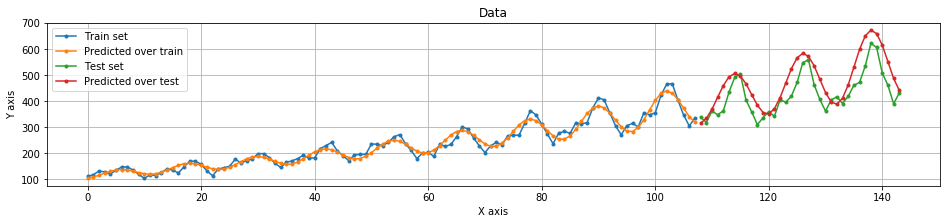

In [7]:
theta_sin = [float(result.x['theta1']), float(result.x['theta2']), float(result.x['theta3']),float(result.x['theta4'])]

X_test = test_set[:,0]
Y_test = test_set[:,1]

Y_train_hat_polsin = np.polyval(theta,X)+ float(result.x['theta1'])*np.sin(float(result.x['theta2'])*X + float(result.x['theta3']))*np.exp(float(result.x['theta4'])*X)
Y_hat_polsin = np.polyval(theta,X_test) + float(result.x['theta1'])*np.sin(float(result.x['theta2'])*X_test + float(result.x['theta3']))*np.exp(float(result.x['theta4'])*X_test)

fig = plt.figure(0,(16,3))
plt.plot(X,Y,'.-')
plt.plot(X,Y_train_hat_polsin,'.-')
plt.plot(X_test,Y_test,'.-')
plt.plot(X_test,Y_hat_polsin ,'.-')
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend(('Train set', 'Predicted over train', 'Test set', 'Predicted over test'))
plt.grid()
plt.savefig('final.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show(fig)

In [8]:
def f_pol_sin(x,a,b):
    return a[3]+a[2]*x+a[1]*np.power(x,2)+a[0]*np.power(x,3)+ b[0]*np.sin(b[1]*x+b[2])*np.exp(b[3]*x)

X = train_set[:,0]

print('X shape: %s' % X.shape)

Y = train_set[:,1]
print('Y shape: %s' % Y.shape)

# Define model
x = mle.var('x', observed=True, vector=True)
y = mle.var('y', observed=True, vector=True)

theta1 = mle.var('theta1')
theta2 = mle.var('theta2')
theta3 = mle.var('theta3')
theta4 = mle.var('theta4')
sigma = mle.var('sigma')


model = mle.Normal(y, f_pol_sin(x,theta,theta_sin) + theta1*tt.sin(theta2*x + theta3)*tt.exp(theta4*x), sigma)


# Fit model to data
result = model.fit({'x': X, 'y': Y}, {'theta1': 10, 'theta2': 1000, 'theta3': -10, 'theta4': 0.1, 'sigma': 100})
print(result)

X shape: 108
Y shape: 108
Optimization terminated successfully.
         Current function value: 415.482938
         Iterations: 121
         Function evaluations: 171
         Gradient evaluations: 166
 fit_time: 0.07673699999999783
      fun: 415.4829381122623
 hess_inv: array([[  5.78802726e-01,  -5.34037211e-03,  -4.61502775e-05,
          2.40083197e-03,   8.03759548e-06],
       [ -5.34037211e-03,   4.62827631e+00,   2.30743837e-04,
         -2.01962749e-02,  -6.21252250e-03],
       [ -4.61502775e-05,   2.30743837e-04,   7.47447744e-06,
         -5.63941546e-04,  -2.94815383e-07],
       [  2.40083197e-03,  -2.01962749e-02,  -5.63941546e-04,
          4.84630275e-02,   2.69669048e-05],
       [  8.03759548e-06,  -6.21252250e-03,  -2.94815383e-07,
          2.69669048e-05,   9.25369522e-06]])
      jac: array([  7.36912753e-10,   6.22325455e-10,   4.46946043e-07,
         1.35632962e-08,   1.42541975e-06])
  message: 'Optimization terminated successfully.'
     nfev: 171
      ni

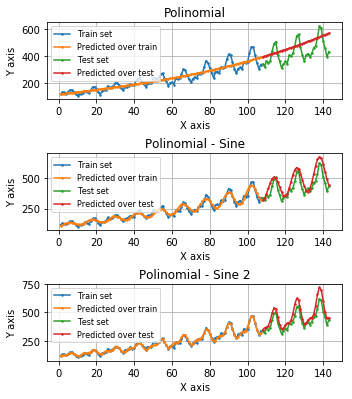

In [25]:
theta_sin_sin = [float(result.x['theta1']), float(result.x['theta2']), float(result.x['theta3']),float(result.x['theta4'])]

X_test = test_set[:,0]
Y_test = test_set[:,1]

Y_train_hat = f_pol_sin(X,theta,theta_sin)+ float(result.x['theta1'])*np.sin(float(result.x['theta2'])*X + float(result.x['theta3']))*np.exp(float(result.x['theta4'])*X)
Y_hat = f_pol_sin(X_test,theta,theta_sin) + float(result.x['theta1'])*np.sin(float(result.x['theta2'])*X_test + float(result.x['theta3']))*np.exp(float(result.x['theta4'])*X_test)

fig, ax = plt.subplots(3,1)
fig.set_figheight(6)
fig.set_figwidth(5)

ax[0].plot(X[1:],Y[1:],'.-', ms = 3)
ax[0].plot(X[1:],Y_train_hat_pol[1:],'.-', ms = 3)
ax[0].plot(X_test,Y_test,'.-', ms = 3)
ax[0].plot(X_test,Y_hat_pol ,'.-', ms = 3)
ax[0].set_title('Polinomial')
ax[0].set_xlabel('X axis')
ax[0].set_ylabel('Y axis')
ax[0].legend(('Train set', 'Predicted over train', 'Test set', 'Predicted over test'), prop={'size':8})
ax[0].grid()

ax[1].plot(X[1:],Y[1:],'.-', ms = 3)
ax[1].plot(X[1:],Y_train_hat_polsin[1:],'.-', ms = 3)
ax[1].plot(X_test,Y_test,'.-', ms = 3)
ax[1].plot(X_test,Y_hat_polsin ,'.-', ms = 3)
ax[1].set_title('Polinomial - Sine')
ax[1].set_xlabel('X axis')
ax[1].set_ylabel('Y axis')
ax[1].legend(('Train set', 'Predicted over train', 'Test set', 'Predicted over test'), prop={'size':8})
ax[1].grid()

ax[2].plot(X[1:],Y[1:],'.-', ms = 3)
ax[2].plot(X[1:],Y_train_hat[1:],'.-', ms = 3)
ax[2].plot(X_test,Y_test,'.-', ms = 3)
ax[2].plot(X_test,Y_hat ,'.-', ms = 3)
ax[2].set_title('Polinomial - Sine 2')
ax[2].set_xlabel('X axis')
ax[2].set_ylabel('Y axis')
ax[2].legend(('Train set', 'Predicted over train', 'Test set', 'Predicted over test'), prop={'size':8})
ax[2].grid()

plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.savefig('final.eps', format = 'eps', bbox_inches = 'tight')
plt.show(fig)

In [10]:
argMSE = (Y_test-Y_hat)**2
MSE = np.mean(argMSE)
print("MSE: %s" % MSE)

MSE: 3303.57468355
